In [263]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations
import csv
import datetime
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson


In [333]:
#phase_dirs = ['../phased_ssc.hg38', '../phased_mssng_quads', '../phased_ihart.ms2_quads']
phase_dirs = ['../phased_ihart.ms2_quads']
assembly = '38'

In [447]:
child_to_num_crossovers_mat = dict()
child_to_num_crossovers_pat = dict()

already_seen = set()
mom_child_pairs = set()
dad_child_pairs = set()
child_pair_to_dataset = dict()

for phase_dir in phase_dirs:
    print(phase_dir)
    for file in sorted(os.listdir(phase_dir)):
        if file.endswith('.crossovers.json'):
            with open('%s/%s' % (phase_dir, file), 'r') as f:
                cos = json.load(f)
                if len(cos)<250:
                    child1, child2 = cos[0]['child']
                    if child1 not in already_seen and child2 not in already_seen:
                        child_to_num_crossovers_mat[(child1, child2)] = len([x for x in cos if x['is_mat']])
                        child_to_num_crossovers_pat[(child1, child2)] = len([x for x in cos if x['is_pat']])
                        already_seen.add(child1)
                        already_seen.add(child2)
                        mom_child_pairs.add((cos[0]['mom'], child1))
                        mom_child_pairs.add((cos[0]['mom'], child2))
                        dad_child_pairs.add((cos[0]['dad'], child1))
                        dad_child_pairs.add((cos[0]['dad'], child2))
                        child_pair_to_dataset[(child1, child2)] = phase_dir
                else:
                    print('Are they related?', file)
    print(len(child_to_num_crossovers_mat))
    
for phase_dir in phase_dirs:
    print(phase_dir)
    for file in sorted(os.listdir(phase_dir)):
        if file.endswith('.gene_conversions.json'):
            with open('%s/%s' % (phase_dir, file), 'r') as f:
                cos = json.load(f)
                if len(cos)<250:
                    child1, child2 = cos[0]['child']
                    if (child1, child2) in child_pair_to_dataset:
                        child_to_num_crossovers_mat[(child1, child2)] += len([x for x in cos if x['is_mat']])
                        child_to_num_crossovers_pat[(child1, child2)] += len([x for x in cos if x['is_pat']])
                else:
                    print('Are they related?', file)
    print(len(child_to_num_crossovers_mat))
            
print(len(child_to_num_crossovers_mat),  len(already_seen))

../phased_ihart.ms2_quads
Are they related? AU0832.AU083203.AU083204.crossovers.json
Are they related? AU0866.AU0866301.AU0866302.crossovers.json
Are they related? AU0905.AU0905301.AU0905302.crossovers.json
Are they related? AU0905.AU0905301.AU0905303.crossovers.json
Are they related? AU0923.AU0923301.AU0923302.crossovers.json
Are they related? AU0941.AU0941301.AU0941302.crossovers.json
Are they related? AU0951.AU0951301.AU0951302.crossovers.json
Are they related? AU1497.AU1497301.AU1497302.crossovers.json
Are they related? AU1497.AU1497301.AU1497303.crossovers.json
Are they related? AU1822.AU1822301.AU1822302.crossovers.json
908
../phased_ihart.ms2_quads
Are they related? AU0832.AU083203.AU083204.gene_conversions.json
Are they related? AU0866.AU0866301.AU0866302.gene_conversions.json
Are they related? AU0905.AU0905301.AU0905302.gene_conversions.json
Are they related? AU0905.AU0905301.AU0905303.gene_conversions.json
Are they related? AU0923.AU0923301.AU0923302.gene_conversions.json
Are

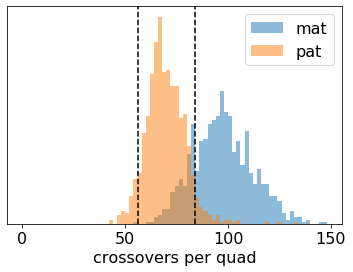

In [448]:
plt.rcParams.update({'font.size': 16})

plt.hist(child_to_num_crossovers_mat.values(), bins=np.arange(0, 150, 2), alpha=0.5, label='mat')
plt.hist(child_to_num_crossovers_pat.values(), bins=np.arange(0, 150, 2), alpha=0.5, label='pat')
plt.axvline(42*2, linestyle='--', color='black')
plt.axvline(28*2, linestyle='--', color='black')
plt.legend()
plt.xlabel('crossovers per quad')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

In [449]:
# pull parental ages
child_to_mom_age_at_birth = dict()
child_to_dad_age_at_birth = dict()
with open('../phenotypes/mssng/agre_affchild1.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    mat_age_index = header.index('MATERNAL_AGE_AT_PARTURITION')
    pat_age_index = header.index('PATERNAL_AGE_AT_PARTURITION')
    for pieces in reader:
        if float(pieces[mat_age_index]) > 10:
            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
        if float(pieces[pat_age_index]) > 10:
            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


92 92


In [450]:
with open('../phenotypes/mssng/rmq.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    mat_age_index = header.index('MOMAGE')
    pat_age_index = header.index('DADAGE')
    for pieces in reader:
        try:
            child_to_mom_age_at_birth[pieces[0]] = float(pieces[mat_age_index])
        except ValueError:
            pass
        try:
            child_to_dad_age_at_birth[pieces[0]] = float(pieces[pat_age_index])
        except ValueError:
            pass
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))


244 241


In [451]:
person_to_birthyear = dict()
filenames = ['../phenotypes/ihart/Medical History Mother/MotherH1.csv',
             '../phenotypes/ihart/Medical History Father/FatherH1.csv',
             '../phenotypes/ihart/Medical History Affected Child/AffChild1.csv',
             '../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv'
            ]

for filename in filenames:
    print(filename)
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('age')
        sample_id_index = header.index('Individual ID')
        date_index = header.index('data_entry_date')
        for pieces in reader:
            try:
                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass
            
with open('../phenotypes/mssng/bodymeas.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('AgeN')
    sample_id_index = header.index('Id')
    date_index = header.index('testdate')
    for pieces in reader:
        try:
            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
            person_to_birthyear[pieces[sample_id_index]] = birth_year
        except ValueError:
            pass
        
with open('../phenotypes/mssng/srsadultresearchform.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('SRSAAGE')
    sample_id_index = header.index('Id')
    date_index = header.index('testdate')
    for pieces in reader:
        try:
            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
            person_to_birthyear[pieces[sample_id_index]] = birth_year
        except ValueError:
            pass
        
with open('../phenotypes/mssng/srsparentreportforchild.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)
    age_index = header.index('SRSAGE')
    sample_id_index = header.index('Id')
    date_index = header.index('testdate')
    for pieces in reader:
        try:
            birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index])/12)).year
            person_to_birthyear[pieces[sample_id_index]] = birth_year
        except ValueError:
            pass

filenames = ['../phenotypes/mssng/agre_srs2srs20021.csv',
             '../phenotypes/mssng/agre_srs2006preschool1.csv',
             '../phenotypes/mssng/agre_srs20061.csv',
            ]
for filename in filenames:
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('AGE')
        sample_id_index = header.index('Id')
        date_index = header.index('testdate')
        for pieces in reader:
            try:
                birth_year = (datetime.datetime.strptime(pieces[date_index], '%m/%d/%y') - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass

        
filenames = ['../phenotypes/ihart/SRS/SRS_2006_Preschool1.csv',
            '../phenotypes/ihart/SRS/SRS_20061_Adult.csv',
            '../phenotypes/ihart/SRS/SRS_20061_Child.csv',
            '../phenotypes/ihart/SRS/SRS_20061.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021_Child.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021_Preschool.csv',
            '../phenotypes/ihart/SRS/SRS2_SRS20021.csv'
            ]
for filename in filenames:
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        age_index = header.index('age')
        sample_id_index = header.index('Individual ID')
        year_index = header.index('InterviewYear')
        month_index = header.index('InterviewMonth')
        day_index = header.index('InterviewDay')
        for pieces in reader:
            try:
                birth_year = (datetime.date(int(pieces[year_index]), int(pieces[month_index]), int(pieces[day_index])) - datetime.timedelta(days=365.25*float(pieces[age_index]))).year
                person_to_birthyear[pieces[sample_id_index]] = birth_year
            except ValueError:
                pass
print(len(person_to_birthyear))


../phenotypes/ihart/Medical History Mother/MotherH1.csv
../phenotypes/ihart/Medical History Father/FatherH1.csv
../phenotypes/ihart/Medical History Affected Child/AffChild1.csv
../phenotypes/ihart/Medical History Unaffected Child/Unaffec1.csv
4152


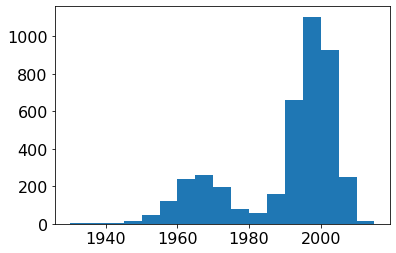

In [452]:
plt.hist(person_to_birthyear.values(), bins=np.arange(1930, 2020, 5))
plt.show()

In [453]:
for mom, child in mom_child_pairs:
    if mom in person_to_birthyear and child in person_to_birthyear:
        age_at_birth = person_to_birthyear[child] - person_to_birthyear[mom]
        if age_at_birth > 10:
            child_to_mom_age_at_birth[child] = age_at_birth
for dad, child in dad_child_pairs:
    if dad in person_to_birthyear and child in person_to_birthyear:
        age_at_birth = person_to_birthyear[child] - person_to_birthyear[dad]
        if age_at_birth > 10:
            child_to_dad_age_at_birth[child] = age_at_birth
print(len(child_to_mom_age_at_birth), len(child_to_dad_age_at_birth))

              

638 627


In [454]:
print(len(child_to_mom_age_at_birth))

print('have ages for ', len(already_seen & set(child_to_mom_age_at_birth.keys())))
print('missing ages for ', len(already_seen - set(child_to_mom_age_at_birth.keys())))

638
have ages for  394
missing ages for  1422


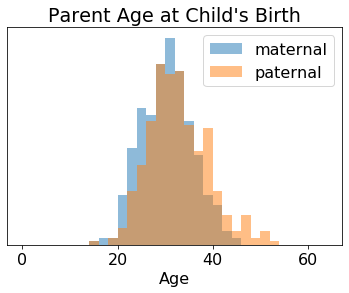

In [455]:
plt.hist(np.clip([child_to_mom_age_at_birth[x] for x in already_seen if x in child_to_mom_age_at_birth], 0, 64),
        alpha=0.5, bins=np.arange(0, 65, 2), label='maternal')
plt.hist(np.clip([child_to_dad_age_at_birth[x] for x in already_seen if x in child_to_dad_age_at_birth], 0, 64),
        alpha=0.5, bins=np.arange(0, 65, 2), label='paternal')
plt.title("Parent Age at Child's Birth")
plt.legend()
plt.xlabel('Age')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()


In [456]:
mom_age, mom_recomb, mom_dataset = [], [], []
dad_age, dad_recomb, dad_dataset = [], [], []
for (child1, child2), cross_mat in child_to_num_crossovers_mat.items():
    if child1 in child_to_mom_age_at_birth and child2 in child_to_mom_age_at_birth:
        mom_age.append(child_to_mom_age_at_birth[child1]+child_to_mom_age_at_birth[child2])
        mom_recomb.append(cross_mat)
        mom_dataset.append([child_pair_to_dataset[(child1, child2)]==d for d in phase_dirs])
        
for (child1, child2), cross_pat in child_to_num_crossovers_pat.items():        
    if child1 in child_to_dad_age_at_birth and child2 in child_to_dad_age_at_birth:
        dad_age.append(child_to_dad_age_at_birth[child1]+child_to_dad_age_at_birth[child2])
        dad_recomb.append(cross_pat)
        dad_dataset.append([child_pair_to_dataset[(child1, child2)]==d for d in phase_dirs])
        
mom_dataset = np.array(mom_dataset)
dad_dataset = np.array(dad_dataset)
mom_age = np.array(mom_age)
dad_age = np.array(dad_age)
mom_recomb = np.array(mom_recomb)
dad_recomb = np.array(dad_recomb)

In [457]:

mat_model = sm.GLM(np.array(mom_recomb), np.hstack((np.array(mom_age)[:, np.newaxis], mom_dataset[:, np.sum(mom_dataset, axis=0)>0])), family=Poisson())
mat_results = mat_model.fit()
mat_results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  194
Model:                            GLM   Df Residuals:                      192
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -855.34
Date:                Sun, 26 Jul 2020   Deviance:                       462.23
Time:                        17:02:01   Pearson chi2:                     471.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0025      0.001      3.523      0.000       0.001       0.004
const          4.4589      0.043    103.770      0.000       4.375       4.543
==============================================================================
"""

In [460]:
mat_results.pvalues

array([0.00042604, 0.        ])

In [458]:

dad_model = sm.GLM(np.array(dad_recomb), np.hstack((np.array(dad_age)[:, np.newaxis], dad_dataset[:, np.sum(dad_dataset, axis=0)>0])), family=Poisson())
dad_results = dad_model.fit()
dad_results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  190
Model:                            GLM   Df Residuals:                      188
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -720.41
Date:                Sun, 26 Jul 2020   Deviance:                       282.02
Time:                        17:02:02   Pearson chi2:                     292.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0010      0.001     -1.406      0.160      -0.002       0.000
const          4.3335      0.047     92.838      0.000       4.242       4.425
==============================================================================
"""

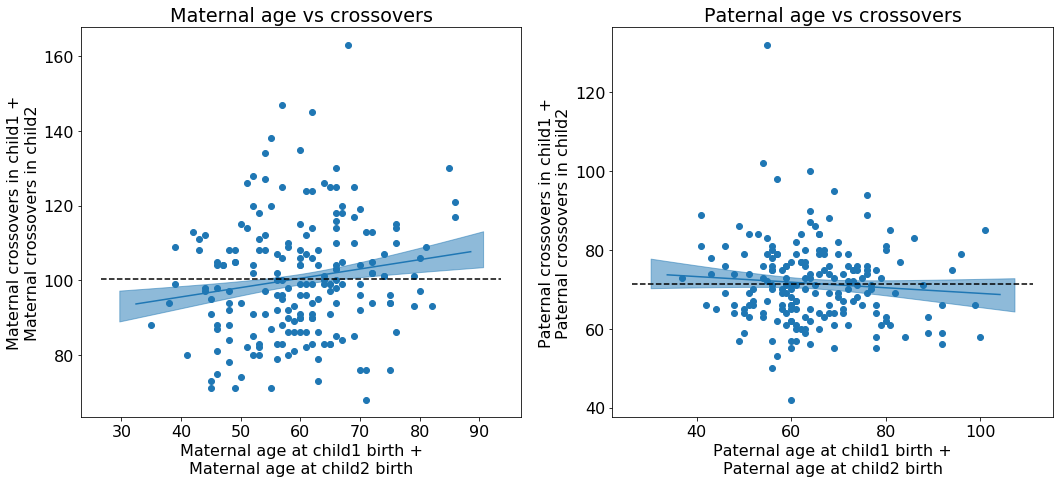

In [459]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(np.array(mom_age), np.array(mom_recomb))
plt.plot(plt.xlim(), np.exp(mat_results.params[1] + mat_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 mat_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(mom_recomb)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Maternal age at child1 birth +\nMaternal age at child2 birth')
plt.ylabel('Maternal crossovers in child1 +\nMaternal crossovers in child2')
plt.title('Maternal age vs crossovers')

plt.subplot(1, 2, 2)
plt.scatter(np.array(dad_age), np.array(dad_recomb))
plt.plot(plt.xlim(), np.exp(dad_results.params[1] + dad_results.params[0]*np.array(plt.xlim())), color=colors[0])
xs = np.arange(plt.xlim()[0], plt.xlim()[1], 1)
plt.fill_between(xs, 
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 0],
                 dad_results.get_prediction(np.hstack((xs[:, np.newaxis], np.ones((xs.shape[0], 1))))).conf_int()[:, 1], alpha=0.5, color=colors[0])
plt.plot(plt.xlim(), np.mean(dad_recomb)*np.ones((2,)), color='black', linestyle='--')

plt.xlabel('Paternal age at child1 birth +\nPaternal age at child2 birth')
plt.ylabel('Paternal crossovers in child1 +\nPaternal crossovers in child2')
plt.title('Paternal age vs crossovers')

plt.tight_layout()
plt.show()